# A MLB Elo model

## Baseline MLB Elo Model

In this notebook I will develop a system for calculating Elo ratings for all 30 current Major League Baseball teams. These Elo calculations will cover from 1998-2024, which is the last year in which the MLB expanded.

Let's begin by taking a look at our data, which I sourced from [Retrosheet](https://www.retrosheet.org/gamelogs/index.html)

In [325]:
import polars as pl

In [326]:
df = pl.read_csv("data/allseasonsgameinfo.csv", infer_schema_length=None)

In [327]:
df.head()

gid,visteam,hometeam,site,date,number,starttime,daynight,innings,tiebreaker,usedh,htbf,timeofgame,attendance,fieldcond,precip,sky,temp,winddir,windspeed,oscorer,forfeit,suspend,umphome,ump1b,ump2b,ump3b,umplf,umprf,wp,lp,save,gametype,vruns,hruns,wteam,lteam,line,batteries,lineups,box,pbp,season
str,str,str,str,i64,i64,str,str,i64,i64,bool,bool,i64,i64,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,i64,i64,str,str,str,str,str,str,str,i64
"""LS3189904140""","""CHN""","""LS3""","""LOU03""",18990414,0,"""0:00PM""","""day""",null,null,false,null,113,11500,"""unknown""","""unknown""","""unknown""","""0""","""unknown""","""-1""",null,null,null,"""burno101""","""warna901""",null,null,null,null,"""grifc101""","""cunnb103""",null,"""regular""",15,1,"""CHN""","""LS3""","""y""","""both""","""y""","""y""",null,1899
"""PHI189904140""","""WSN""","""PHI""","""PHI09""",18990414,0,"""0:00PM""","""day""",null,null,false,null,120,12000,"""unknown""","""unknown""","""unknown""","""0""","""unknown""","""-1""",null,null,null,"""huntj901""","""connt901""",null,null,null,null,"""piatw101""","""killf101""",null,"""regular""",5,6,"""PHI""","""WSN""","""y""","""both""","""y""","""y""",null,1899
"""BLN189904150""","""NY1""","""BLN""","""BAL07""",18990415,0,"""0:00PM""","""day""",null,null,false,null,130,3912,"""unknown""","""unknown""","""unknown""","""0""","""unknown""","""-1""",null,null,null,"""emslb101""","""bettw901""",null,null,null,null,"""kitsf101""","""dohee101""",null,"""regular""",3,5,"""BLN""","""NY1""","""y""","""both""","""y""","""y""",null,1899
"""BRO189904150""","""BSN""","""BRO""","""NYC12""",18990415,0,"""0:00PM""","""day""",null,null,false,null,120,20167,"""unknown""","""unknown""","""unknown""","""0""","""unknown""","""-1""",null,null,null,"""andre101""","""gaffj801""",null,null,null,null,"""nichk101""","""kennb101""",null,"""regular""",1,0,"""BSN""","""BRO""","""y""","""both""","""y""","""y""",null,1899
"""CIN189904150""","""PIT""","""CIN""","""CIN05""",18990415,0,"""0:00PM""","""day""",null,null,false,null,130,10000,"""unknown""","""unknown""","""unknown""","""0""","""unknown""","""-1""",null,null,null,"""sware101""","""warna901""",null,null,null,null,"""tannj101""","""hawlp101""",null,"""regular""",5,2,"""PIT""","""CIN""","""y""","""both""","""y""","""y""",null,1899


Let's look at the value counts of the game type column, as we will only consider regular season games in this analysis for fairness

In [328]:
df.select(pl.col("gametype").value_counts())

gametype
struct[2]
"{""wildcard"",62}"
"{""regular"",210608}"
"{""worldseries"",700}"
"{""allstar"",94}"
"{""playoff"",22}"
"{""divisionseries"",495}"
"{""lcs"",574}"


Let's keep only games from the regular season

In [329]:
df = df.filter(pl.col("gametype") == "regular")

Next, we'll use the season column to restrict our data to only include games from 1998-2024

In [330]:
df = df.filter(pl.col("season") >= 1998)

Just for ease of use later, let's convert the date column to a proper date type

In [331]:
df = df.with_columns(
    pl.col("date").cast(pl.String).str.strptime(pl.Date, format="%Y%m%d")
)

In [332]:
df.select(pl.col("date"))

date
date
1998-03-31
1998-03-31
1998-03-31
1998-03-31
1998-03-31
…
2024-09-29
2024-09-29
2024-09-29


Finally, Retrosheet provides a lot of data which we don't really need so let's just keep the columns that we care about. These columns are:

- visteam -> visiting team name
- hometeam -> home team name
- date -> used for sorting data and checking when seasons shift (i'll get to that later)
- number -> game number for a dates with multiple games (doubleheaders, etc)
- vruns -> runs scored by visiting team
- hruns -> runs scored by home team

In [333]:
df = df.select(
    pl.col(["visteam", "hometeam", "date", "vruns", "hruns", "season", "number"])
)

In [334]:
df.head()

visteam,hometeam,date,vruns,hruns,season,number
str,str,date,i64,i64,i64,i64
"""COL""","""ARI""",1998-03-31,9,2,1998,0
"""MIL""","""ATL""",1998-03-31,1,2,1998,0
"""KCA""","""BAL""",1998-03-31,4,1,1998,0
"""SDN""","""CIN""",1998-03-31,10,2,1998,0
"""CHN""","""FLO""",1998-03-31,6,11,1998,0


Now let's do a bit of validation on the columns that we have

In [335]:
print(
    df.select(pl.col("visteam").n_unique()).item(),
    df.select(pl.col("hometeam").n_unique()).item(),
)

32 32


We have 32 teams when we really expect 30, let's investigate

In [336]:
team_codes = list(
    set(df.select(pl.col("hometeam").unique()).to_series().to_list()).intersection(
        set(df.select(pl.col("visteam").unique()).to_series().to_list())
    )
)
print(team_codes)

['OAK', 'MIN', 'ANA', 'TEX', 'BAL', 'SDN', 'TBA', 'WAS', 'CLE', 'SFN', 'KCA', 'TOR', 'MIL', 'CHA', 'CHN', 'COL', 'MON', 'SLN', 'ATL', 'ARI', 'CIN', 'PIT', 'MIA', 'BOS', 'DET', 'PHI', 'SEA', 'NYA', 'HOU', 'FLO', 'NYN', 'LAN']


Luckily, Retrosheet provides comprehensive data on all teams in their data as well as their team codes

In [337]:
teams_df = pl.read_csv("data/teams.csv")

In [338]:
teams_df.head()

TEAM,LEAGUE,CITY,NICKNAME,FIRST,LAST
str,str,str,str,i64,i64
"""ACY""","""ECL""","""Atlantic City""","""Bacharach Giants""",1916,1929
"""AGS""",null,"""Augie Galan""","""All Stars""",1944,1944
"""AKR""",null,"""Akron""","""Grays""",1933,1933
"""ALM""",null,"""American League""","""Stars in Mexico""",1935,1935
"""ALN""",null,"""American League""","""All Stars""",1926,1930


In [339]:
teams_df = teams_df.filter(pl.col("TEAM").is_in(team_codes))
names = {}
for row in teams_df.select(pl.col(["TEAM", "NICKNAME"])).iter_rows():
    names[row[0]] = row[1]

Ok, so we seem to be getting 32 teams because the Miami Marlins were formerly known as the Florida Marlins, and in 2005 the Montreal Expos became the Washington Nationals. Since both of these teams are continuations of the old teams, we will just rename them.

In [340]:
df = df.with_columns(
    pl.when(pl.col("hometeam") == "MON")
    .then(pl.lit("WAS"))
    .when(pl.col("hometeam") == "FLO")
    .then(pl.lit("MIA"))
    .otherwise(pl.col("hometeam"))
    .alias("hometeam"),
    pl.when(pl.col("visteam") == "MON")
    .then(pl.lit("WAS"))
    .when(pl.col("visteam") == "FLO")
    .then(pl.lit("MIA"))
    .otherwise(pl.col("visteam"))
    .alias("visteam"),
)

In [341]:
df = df.with_columns(
    pl.col("visteam").replace(names), pl.col("hometeam").replace(names)
)

In [342]:
df.head()

visteam,hometeam,date,vruns,hruns,season,number
str,str,date,i64,i64,i64,i64
"""Rockies""","""Diamondbacks""",1998-03-31,9,2,1998,0
"""Brewers""","""Braves""",1998-03-31,1,2,1998,0
"""Royals""","""Orioles""",1998-03-31,4,1,1998,0
"""Padres""","""Reds""",1998-03-31,10,2,1998,0
"""Cubs""","""Marlins""",1998-03-31,6,11,1998,0


In [343]:
team_codes = list(
    set(df.select(pl.col("hometeam").unique()).to_series().to_list()).intersection(
        set(df.select(pl.col("visteam").unique()).to_series().to_list())
    )
)
print(len(team_codes))

30


Great! Now we have 30 teams to work with, as expected.

Let's now go into the actual workings of how our Elo calculation will work.

Fundamentally Elo is based on head to head matchups, where the result of each matchup will update each teams' ratings based on the expected performance vs actual performance.

A classical Elo system works as follows:

The expected win probability between two teams (A and B) is dependent on their ratings prior to the game.

Let $E_A$ be the expected win probability for Team A. Our formula will be $E_A = \frac{1}{1+ 10^{\frac{(R_B - R_A)}{400}}}$, and since Elo is a zero sum system $E_B = 1 - E_A$

After each game, each team's rating is then adjusted by how much they over or underperformed (essentially margin of victory / defeat).

Let $R'_A$ be the updated ratings for Team A after some match. Our formula for $R'_A = R_A + K(S_A - E_A)$ where $S_A$ is 1 for a win and 0 for a loss, while $K$ is a constant which controls how fast ratings change.

Since baseball has no draws and margin of victory is extremely important in deciding if a team over performed or underperformed we will adjust the classical approach as follows:

We will keep $S_A$ and $E_A$ as previously defined, but we will scale the rating update by a margin factor that gives larger adjustments for blowouts with diminishing returns as the score margin (MOV) decreases. Additionally we will add a home field rating adjustment of +24 points for the home team and +0 points for the away team.

Our final adapted formulas then become:

- $E_A = \frac{1}{1+ 10^{\frac{(R_B - R_A)}{400}}}$
  
- $f(MOV) = ln(MOV+1) \times \frac{2.2}{((R_A - R_B) \times .0001) + 2.2}$

- $R'_A = R_A + K \times f(MOV) \times (S_A - E_A)$

- $R_{A,adj}​=R_A​+H_A​,R_{B,adj}​=R_B​+H_B​$ (we substitute $R_{A,adj}$ and $R_{B,adj}$ for $R_A$ and $R_B$ above)


We then encode these as the following python functions.

In [344]:
def expected_win_probability(r_a: float, r_b: float) -> float:
    """Returns expected win probability E_A based on the provided ratings.


    Args:
        float (r_a): Pre-adjusted rating for Team A
        float (r_b): Pre-adjusted rating for Team B
    Returns:
        float: expected win probability for Team A
    """

    return 1 / (1 + (10 ** ((r_b - r_a) / 400)))

To smoke test this function, let's pass in 1500 for r_a and 1300 for r_b, we expect to get a value around 0.75

In [345]:
print(expected_win_probability(r_a=1500, r_b=1300))

0.7597469266479578


In [346]:
import math

In [347]:
def mov_multiplier(MOV: int, r_a: float, r_b: float) -> float:
    """Returns mov_multiplier based on score margin of game.

    Args:
        MOV (int): absolute run differential for Team A (i.e |runs_scored_a - runs_scored_b|)
        r_a (float): Pre-adjusted rating for Team A
        r_b (float): Pre-adjusted rating for Team B

    Returns:
        float: MOV multiplier
    """
    return math.log(MOV + 1) * (2.2 / ((r_a - r_b) * 0.001 + 2.2))

In [348]:
def rating_update(
    initial_rating_a: float,
    initial_rating_b: float,
    K: int,
    MOV: int,
    team_a_won: bool,
) -> tuple[float, float]:
    s_a = 0
    s_b = 1
    if team_a_won:
        s_a = 1
        s_b = 0
    expected_win_probability_a = expected_win_probability(
        initial_rating_a + 40,  # team A will always be the home team
        initial_rating_b,
    )
    expected_win_probability_b = 1 - expected_win_probability_a
    multiplier = mov_multiplier(
        MOV,
        initial_rating_a + 40,
        initial_rating_b,
    )

    updated_rating_a = initial_rating_a + K * multiplier * (
        s_a - expected_win_probability_a
    )

    updated_rating_b = initial_rating_b + K * multiplier * (
        s_b - expected_win_probability_b
    )

    return (
        updated_rating_a,
        updated_rating_b,
        expected_win_probability_a,
        expected_win_probability_b,
    )

In [349]:
rating_update(1600, 1550, 30, 5, True)

(1619.2773449997733,
 1530.7226550002267,
 0.626699081666732,
 0.37330091833326795)

We will also add season by season regression which is implemented by the following function. Season regression is important in baseball Elo as rosters change significantly year to year, and we want to make sure that a team's Elo rating reflects their current roster strength as much as possible.

In [ ]:
def regress_between_seasons(
    ratings: dict[str, float], mean: float = 1500, retention: float = 0.85
):
    """Regresses team ratings toward the mean between seasons."""
    for team in ratings:
        ratings[team] = mean + retention * (ratings[team] - mean)
    return ratings

We will sort the data by date to ensure that games are processed in the correct order.

In [351]:
df = df.sort(by=["date", "number"])

Our elo creation loop will work as follows.
1. Initialize all teams to the same rating (1500)
2. Iterate through the data season by season, calculating Elo, then regressing
3. Repeat until all seasons are processed

In [352]:
seasons = df.select(pl.col("season").unique()).to_series().to_list()


To evaluate our model, we will use Brier Score, which is a proper score function that measures the accuracy of probabilistic predictions. The Brier score is calculated as the mean squared difference between predicted probabilities and the actual outcomes. A lower Brier score indicates better accuracy, with a perfect score being 0.

The formula for Brier Score is: $BS = \frac{1}{N} \sum_{i=1}^{N} (E_i - S_i)^2$ 

Where:
- N is the total number of predictions
- $E_i$ is the predicted probability of the outcome
- $S_i$ is the actual outcome (1 if the team actually won, 0 otherwise)

In [ ]:
def run_elo(games_df, seasons):
    # initialize ratings
    ratings = {
        team: 1500
        for team in games_df.select(pl.col("hometeam").unique()).to_series().to_list()
    }
    predictions = []
    # loop through seasons in increasing order
    for season in sorted(seasons):
        season_games = games_df.filter(
            pl.col("season") == season
        )  # retrieve games for the season
        season_games = season_games.sort(
            by=["date", "number"]
        )  # ensure games are in chronological order
        for row in season_games.iter_rows():
            vis_team, home_team, vis_runs, home_runs = row[0], row[1], row[3], row[4]
            MOV = abs(home_runs - vis_runs)
            home_team_won = home_runs > vis_runs

            (
                new_home_rating,
                new_vis_rating,
                expected_win_probability_home,
                expected_win_probability_vis,
            ) = rating_update(
                ratings[home_team],
                ratings[vis_team],
                K=5,
                MOV=MOV,
                team_a_won=home_team_won,
            )
            ratings[home_team] = new_home_rating
            ratings[vis_team] = new_vis_rating
            predictions.append(
                (expected_win_probability_home, int(home_team_won))
            )  # store predictions for brier score
        ratings = regress_between_seasons(ratings, mean=1500, retention=0.85)
    return ratings, predictions

Now let's run our Elo function on the data and print out the final ratings for each team.

In [376]:
ratings, predictions = run_elo(df, seasons)

ratings = {
    k: v for k, v in sorted(ratings.items(), key=lambda item: item[1], reverse=True)
}  # sort ratings descending by elo score

for k in ratings.keys():
    print(f"Team: {k}. Final Elo rating: {ratings[k]}.")


Team: Dodgers. Final Elo rating: 1565.2888067165652.
Team: Padres. Final Elo rating: 1549.9682241159694.
Team: Braves. Final Elo rating: 1547.5320378641218.
Team: Brewers. Final Elo rating: 1546.0099621135064.
Team: Astros. Final Elo rating: 1545.326269592249.
Team: Phillies. Final Elo rating: 1535.3133519806122.
Team: Diamondbacks. Final Elo rating: 1535.3000557607763.
Team: Mets. Final Elo rating: 1533.1658653367224.
Team: Mariners. Final Elo rating: 1532.236648607231.
Team: Yankees. Final Elo rating: 1531.4366491104602.
Team: Cubs. Final Elo rating: 1524.2005784174369.
Team: Orioles. Final Elo rating: 1523.7161314923803.
Team: Guardians. Final Elo rating: 1515.6313436714233.
Team: Tigers. Final Elo rating: 1512.2913956828675.
Team: Devil Rays. Final Elo rating: 1507.7349539105426.
Team: Royals. Final Elo rating: 1506.467520740569.
Team: Giants. Final Elo rating: 1500.140243129995.
Team: Cardinals. Final Elo rating: 1497.1568270092048.
Team: Red Sox. Final Elo rating: 1491.6432233338

As mentioned earlier, we will also calculate the Brier score to evaluate our predictions.


In [377]:
pred_df = pl.DataFrame(
    predictions, schema=["predicted_probability", "actual_outcome"], orient="row"
)

pred_df = pred_df.with_columns(
    ((pl.col("predicted_probability") - pl.col("actual_outcome")) ** 2).alias(
        "squared_error"
    )
)

brier_score = pred_df.select(pl.col("squared_error").mean()).item()
print(f"Brier Score of baseline Elo predictions: {brier_score}")

Brier Score of baseline Elo predictions: 0.24436507089018827


This value of around .244 indicates that our predictions could be improved, as a perfect Brier score is 0 and .25 represents random guessing. However, given the complexity and unpredictability of baseball games, this is a reasonable starting point for our Elo model. 

Let's also take a look at the calibration of our predictions by plotting a reliability diagram. A reliability diagram plots predicted probabilities against actual outcomes to visualize how well the predicted probabilities align with observed frequencies. We'll group our predictions into bins and calculate the average predicted probability and actual outcome for each bin. We'll also plot a reference line representing perfect calibration for comparison. Additionally, we'll include an error band to visualize the uncertainty in our estimates.

In [363]:
import numpy as np

bins = np.arange(0, 1.1, 0.1)


def get_probability_bin(prob):
    """Map probability to bin label."""
    bin_index = min(int(prob * 10), 9)  # 0-9 for 10 bins
    return f"{bins[bin_index]:.1f}-{bins[bin_index + 1]:.1f}"


pred_df = pred_df.with_columns(
    pl.col("predicted_probability")
    .map_elements(get_probability_bin, return_dtype=pl.Utf8)
    .alias("probability_bin")
)

calibration_df = (
    pred_df.group_by("probability_bin")
    .agg(
        [
            pl.col("predicted_probability").mean().alias("avg_predicted_probability"),
            pl.col("actual_outcome").mean().alias("actual_outcome_rate"),
            pl.len().alias("count"),
        ]
    )
    .sort("probability_bin")
)


# error bars for actual outcome rate
calibration_df = calibration_df.with_columns(
    (
        pl.col("actual_outcome_rate")
        * (1 - pl.col("actual_outcome_rate"))
        / pl.col("count")
    )
    .sqrt()
    .alias("std_error")
)

calibration_df = calibration_df.with_columns(
    (pl.col("actual_outcome_rate") - 1.96 * pl.col("std_error")).alias("lower_bound"),
    (pl.col("actual_outcome_rate") + 1.96 * pl.col("std_error")).alias("upper_bound"),
)

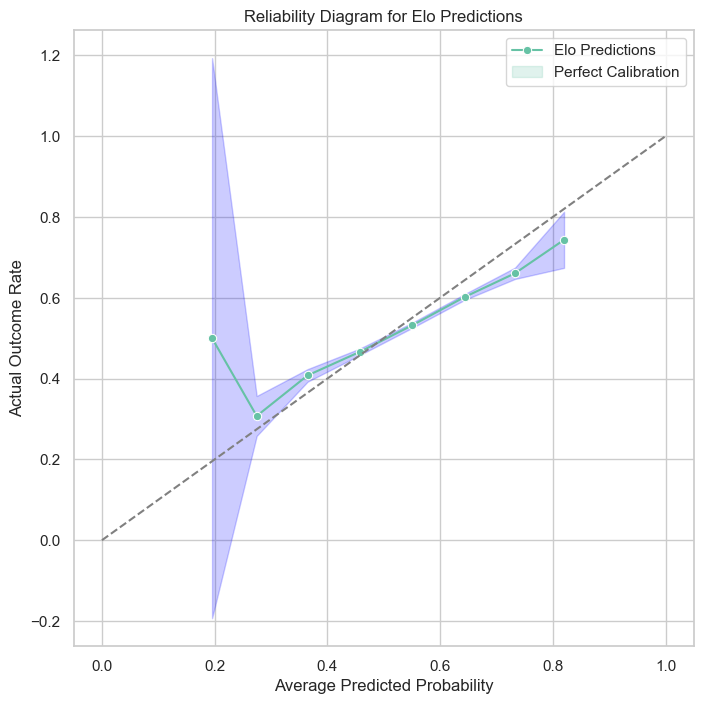

In [364]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
sns.set_palette("Set2")
plt.figure(figsize=(8, 8))
sns.lineplot(
    x=calibration_df.select("avg_predicted_probability").to_series(),
    y=calibration_df.select("actual_outcome_rate").to_series(),
    marker="o",
)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", color="gray")  # reference line
plt.fill_between(
    calibration_df.select("avg_predicted_probability").to_series(),
    calibration_df.select("lower_bound").to_series(),
    calibration_df.select("upper_bound").to_series(),
    color="blue",
    alpha=0.2,
)
plt.xlabel("Average Predicted Probability")
plt.ylabel("Actual Outcome Rate")
plt.title("Reliability Diagram for Elo Predictions")
plt.grid(True)
plt.legend(["Elo Predictions", "Perfect Calibration"])
plt.show()

This looks pretty good! Our predictions are fairly well calibrated, as they generally follow the y=x line. There are some deviations, particularly at the extremes, but overall the model seems to be performing reasonably well in terms of calibration. The error bands also give us an idea of the uncertainty in our estimates, which is important to consider when interpreting the results. Let's investigate what's happening in thos extreme regions. My hunch is that there are fewer data points in those regions, leading to higher uncertainty and more pronounced deviations from perfect calibration.

In [365]:
print(
    pred_df.select(pl.col("probability_bin").value_counts())
    .unnest("probability_bin")
    .sort(by="count")
)

shape: (8, 2)
┌─────────────────┬───────┐
│ probability_bin ┆ count │
│ ---             ┆ ---   │
│ str             ┆ u32   │
╞═════════════════╪═══════╡
│ 0.1-0.2         ┆ 2     │
│ 0.8-0.9         ┆ 152   │
│ 0.2-0.3         ┆ 335   │
│ 0.3-0.4         ┆ 3835  │
│ 0.7-0.8         ┆ 4378  │
│ 0.4-0.5         ┆ 14566 │
│ 0.6-0.7         ┆ 17562 │
│ 0.5-0.6         ┆ 23226 │
└─────────────────┴───────┘


As expected, we see that the extreme bins (very low and very high predicted probabilities) have significantly fewer data points compared to the middle bins. This is especially pronounced in the 0.1-0.2 bin which has only 2 data points. Similarly, the other 2 extreme bins (0.8-0.9 and 0.2-0.3) also have relatively low counts compared to the other bins. This is actually a natural result from such a system as the logistic transformation we apply when calculating expected win probabilities tends to compress values towards the center of the distribution. As a result, we have fewer instances where teams are predicted to have very high or very low probabilities of winning, leading to less data in those extreme bins which in turn leads to higher uncertainty and more pronounced deviations from perfect calibration in those regions.

I'm also interested in looking at the Log Loss (Cross-Entropy) metric for our predictions as this metric is more sensitive to extreme mispredictions compared to Brier Score. Log Loss penalizes incorrect predictions more heavily when the predicted probability is far from the actual outcome, making it a useful metric for evaluating the quality of probabilistic predictions. 

The formula for Log Loss is: $LL = -\frac{1}{N} \sum_{i=1}^{N} [S_i \cdot log(E_i) + (1 - S_i) \cdot log(1 - E_i)]$ 

Where:
- N is the total number of predictions
- $E_i$ is the predicted probability of the outcome
- $S_i$ is the actual outcome (1 if the team actually won, 0 otherwise)

In [374]:
pred_df = pred_df.with_columns(
    pl.when(pl.col("actual_outcome") == 1)
    .then(pl.col("predicted_probability").log())
    .otherwise((1 - pl.col("predicted_probability")).log())
    .alias("log_loss_component")
)

log_loss = -pred_df.select(pl.col("log_loss_component").mean()).item()
print(f"Log Loss of baseline Elo predictions: {log_loss}")

Log Loss of baseline Elo predictions: 0.6825757406059277


Again, this log loss value of around .683 is slightly better than random guessing, which would yield a log loss of around .693 for a balanced dataset. This indicates that while our model is making some useful predictions, there is still significant room for improvement. Given the complexity of baseball and the many factors that can influence game outcomes, achieving a low log loss is challenging. However, this metric provides a useful benchmark for evaluating future improvements to our Elo model.

## Tuning the hyperparameters of our MLB Elo model

Now that we've established a baseline Elo model for MLB, we can look into tuning the hyperparameters to potentially improve our model's performance. The hyperparameters we will tune are:
1. K-factor: Controls sensitivity of Elo ratings to game outcomes. Higher values lead to larger rating changes.
2. Home Field Advantage (HFA): Controls how much of a bump in Elo rating the home team receives to account for home field advantage.
3. MOV Scaling Factor: Adjusts how much the margin of victory influences the rating updates.
4. Season Regression Factor: Determines how much a team's Elo rating regresses towards the mean at the start of each new season.

To handle this, we'll slightly change all of our Elo functions to be more flexible with respect to these hyperparameters, allowing us to easily adjust them during our tuning process.

In [378]:
def rating_update(
    initial_rating_a: float,
    initial_rating_b: float,
    K: int,
    MOV: int,
    team_a_won: bool,
    home_field_adv: int = 40,
) -> tuple[float, float]:
    s_a = 0
    s_b = 1
    if team_a_won:
        s_a = 1
        s_b = 0
    expected_win_probability_a = expected_win_probability(
        initial_rating_a + home_field_adv,  # team A will always be the home team
        initial_rating_b,
    )
    expected_win_probability_b = 1 - expected_win_probability_a
    multiplier = mov_multiplier(
        MOV,
        initial_rating_a + home_field_adv,
        initial_rating_b,
    )

    updated_rating_a = initial_rating_a + K * multiplier * (
        s_a - expected_win_probability_a
    )

    updated_rating_b = initial_rating_b + K * multiplier * (
        s_b - expected_win_probability_b
    )

    return (
        updated_rating_a,
        updated_rating_b,
        expected_win_probability_a,
        expected_win_probability_b,
    )

In [384]:
def run_elo(
    games_df, seasons, K=32, home_field_adv=40, mov_scaling=1.0, season_regression=0.75
):
    # initialize ratings
    ratings = {
        team: 1500
        for team in games_df.select(pl.col("hometeam").unique()).to_series().to_list()
    }
    history = []
    # loop through seasons in increasing order
    for season in sorted(seasons):
        season_games = games_df.filter(
            pl.col("season") == season
        )  # retrieve games for the season
        season_games = season_games.sort(
            by=["date", "number"]
        )  # ensure games are in chronological order
        for row in season_games.iter_rows():
            vis_team, home_team, vis_runs, home_runs = row[0], row[1], row[3], row[4]
            MOV = abs(home_runs - vis_runs)
            home_team_won = home_runs > vis_runs

            (
                new_home_rating,
                new_vis_rating,
                expected_win_probability_home,
                expected_win_probability_vis,
            ) = rating_update(
                ratings[home_team],
                ratings[vis_team],
                K=K,
                MOV=MOV * mov_scaling,
                team_a_won=home_team_won,
                home_field_adv=home_field_adv,
            )
            ratings[home_team] = new_home_rating
            ratings[vis_team] = new_vis_rating
            history.append(
                {
                    "season": season,
                    "home_team": home_team,
                    "vis_team": vis_team,
                    "predicted_probability": expected_win_probability_home,
                    "actual_outcome": int(home_team_won),
                }
            )  # store predictions for brier score
        ratings = regress_between_seasons(
            ratings, mean=1500, retention=season_regression
        )
    return ratings, pl.DataFrame(history)

Let's also add a helper function that takes in the results of our Elo run and computes the corresponding Brier Score for easy evaluation.

In [387]:
def compute_brier_score(df: pl.DataFrame) -> float:
    return ((df["predicted_probability"] - df["actual_outcome"]) ** 2).mean()

Our hyperparameter search function will work as follows:
1. Define ranges for each hyperparameter to explore.
2. Iterate through all combinations of hyperparameters.
3. For each combination, run the Elo model and compute the Brier Score.
4. Keep track of the best performing hyperparameter combination based on Brier Score.
5. Return the best hyperparameter combination and its corresponding Brier Score.

In [ ]:
import itertools

param_grid = {
    "K": [2, 4, 8, 16, 24, 32, 64],
    "home_field_adv": [10, 15, 25, 40, 55],
    "mov_scaling": [0.5, 0.75, 1.0, 1.25, 1.5],
    "season_regression": [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
}

In [401]:
results = []
games_df = df  # renaming for clarity
for params in itertools.product(*param_grid.values()):
    K, home_field_adv, mov_scaling, season_regression = params
    _, history = run_elo(
        games_df,
        seasons,
        K=K,
        home_field_adv=home_field_adv,
        mov_scaling=mov_scaling,
        season_regression=season_regression,
    )
    brier = compute_brier_score(history)
    print(f"Completed params: {params} with Brier score: {brier}")

    results.append(
        {
            "K": K,
            "home_field_adv": home_field_adv,
            "mov_scaling": mov_scaling,
            "season_regression": season_regression,
            "brier": brier,
        }
    )

results_df = pl.DataFrame(results).sort("brier")

Completed params: (2, 10, 0.5, 0.7) with Brier score: 0.24459718872248998
Completed params: (2, 10, 0.5, 0.75) with Brier score: 0.24459679907314316
Completed params: (2, 10, 0.5, 0.8) with Brier score: 0.24464218113801292
Completed params: (2, 10, 0.5, 0.85) with Brier score: 0.2447472521399201
Completed params: (2, 10, 0.5, 0.9) with Brier score: 0.24493118135653583
Completed params: (2, 10, 0.5, 0.95) with Brier score: 0.24522131911131112
Completed params: (2, 10, 0.75, 0.7) with Brier score: 0.24432477060295735
Completed params: (2, 10, 0.75, 0.75) with Brier score: 0.2443470400709053
Completed params: (2, 10, 0.75, 0.8) with Brier score: 0.24441269105952962
Completed params: (2, 10, 0.75, 0.85) with Brier score: 0.24453236807802203
Completed params: (2, 10, 0.75, 0.9) with Brier score: 0.24472011655177628
Completed params: (2, 10, 0.75, 0.95) with Brier score: 0.24499510765779275
Completed params: (2, 10, 1.0, 0.7) with Brier score: 0.24418753630929368
Completed params: (2, 10, 1.

In [402]:
results_df.sort("brier").head(10)

K,home_field_adv,mov_scaling,season_regression,brier
i64,i64,f64,f64,f64
4,25,0.5,0.7,0.243526
4,25,0.75,0.7,0.243554
2,25,1.5,0.7,0.24356
2,25,1.25,0.7,0.243607
2,25,1.5,0.75,0.243608
4,25,0.5,0.75,0.243609
4,25,1.0,0.7,0.243637
4,25,0.75,0.75,0.243646
2,25,1.25,0.75,0.24365


Unfortunately, it seems that the model did not improve significantly with hyperparameter tuning. The best Brier score we achieved was approximately 0.2435, which is only a slight improvement over our baseline model's Brier score of around 0.2446. Ultimately, this suggests that the predictive power of our Elo model is limited, and further improvements may require incorporating additional factors or using more sophisticated modeling techniques beyond simple Elo ratings.